In [4]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

## Load RF Model

In [5]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = '../models/housing_pricing_RF_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        rf_model = pickle.load(f)
    if rf_model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if rf_model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model version doesn't match version loaded


## Load Data<a id='5.5_Load_Data'></a>

In [6]:
housing_data = pd.read_csv('../data/housing_data_lr_rf.csv')
housing_data.dtypes

Zip_Code                   int64
Nr_Bedrooms                int64
Nr_Bathrooms             float64
Approx_SQFT                int64
Year_Built                 int64
                          ...   
Payment_Fixed              int64
Payment_Graduated          int64
Payment_Interest Only      int64
Payment_Missing            int64
Payment_Other              int64
Length: 63, dtype: object

Create a variable containing all listings sold for $600,000

In [7]:
Sold_Price_600000 = housing_data[housing_data.Sold_Price == 600000]

In [8]:
Sold_Price_600000.shape

(17, 63)

In [9]:
Sold_Price_600000.T

,5,488,503,846,1359,1821,1957,1982,2044,2147,2199,2509,2554,2610,2659,2679,2786
Zip_Code,85003.0,85028.0,85028.0,85048.0,85202.0,85212.0,85225.0,85225.0,85233.0,85249.0,85249.0,85257.0,85258.0,85259.0,85260.0,85260.0,85268.0
Nr_Bedrooms,1.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0
Nr_Bathrooms,1.0,2.5,2.0,2.5,2.0,3.5,2.5,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.5
Approx_SQFT,893.0,2072.0,1706.0,2331.0,1672.0,3050.0,2957.0,2288.0,1818.0,2185.0,1845.0,1604.0,1104.0,1735.0,1938.0,1938.0,2132.0
Year_Built,2016.0,1971.0,1971.0,1986.0,1976.0,2020.0,1993.0,1999.0,1993.0,2004.0,2013.0,1969.0,1987.0,2006.0,1981.0,1981.0,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Payment_Fixed,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
Payment_Graduated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Payment_Interest Only,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Payment_Missing,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Refit Model On All Available Data (excluding Zipcode 85202)

In this next step I want to refit the model using all available data. But should we include the data in zipcode 85202 data? On the one hand, we are _not_ trying to estimate model performance on a previously unseen data sample, so theoretically including 85202 zipcode data should be fine. One might first think that including 85202 zipcode in the model training would, if anything, improve model performance in predicting a, for example, a home valued at 600,000 in zipcode 85202. But here's where our project context comes in. The motivation for this entire project is based on the sense that a 600000 valued home in 85202 zipcode needs to pe predicted as close as possible to actual sold price of 600,000. One way to phrase this problem: we want to train a model to predict a 600,000 valued home in zipcode 85202 based on data from _all the other_ zipcodes! We don't want 85202 zipcode current Sold price to bias this. We want to calculate a price based only on its other zipcodes data.

In [10]:
X_rf = housing_data.loc[housing_data.Zip_Code != 85202, rf_model.X_columns]
y_rf = housing_data.loc[housing_data.Zip_Code != 85202, 'Sold_Price']

In [11]:
len(X_rf), len(y_rf)

(3076, 3076)

In [12]:
rf_model.fit(X_rf, y_rf)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=112, random_state=47))])

In [13]:
cv_results = cross_validate(rf_model, X_rf, y_rf, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [14]:
cv_results['test_score']

array([-195505.41443936,  -92185.82680023, -100952.56125145,
       -218185.35355691, -413852.74218931])

In [15]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(204136.37964745294, 116131.5173479611)

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent, and they are. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

## Calculate Expected Sold Price for a house valued at 600,000 using RF Model

In [16]:
X_85202_rf = housing_data.loc[housing_data.Sold_Price == 600000, rf_model.X_columns]
y_85202_rf = housing_data.loc[housing_data.Sold_Price == 60000]

In [17]:
zipcode_85202_pred_rf = rf_model.predict(X_85202_rf)

In [18]:
zipcode_85202_pred_rf

array([554222.32142857, 624007.14285714, 554574.09821429, 643469.64285714,
       460930.53571429, 639442.125     , 653585.25892857, 593298.96428571,
       581969.01785714, 631360.875     , 570840.80357143, 613508.92857143,
       501381.25      , 617531.91964286, 623363.82142857, 619955.        ,
       617134.92857143])

In [19]:
zipcode_85202_pred_rf.mean()

594151.5667016807

In [20]:
zipcode_85202_pred_rf.min()

460930.53571428574

In [21]:
zipcode_85202_pred_rf.max()

653585.2589285715

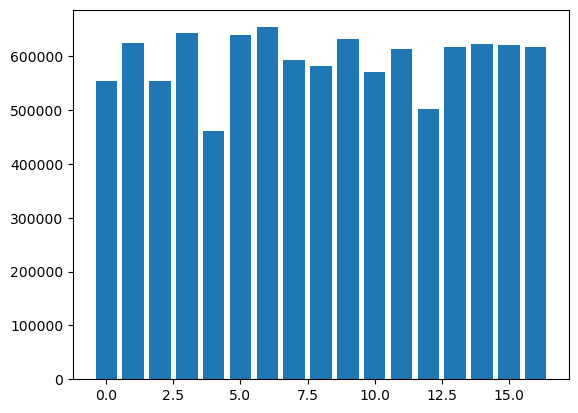

In [22]:
plt.bar(np.arange(len(zipcode_85202_pred_rf)),zipcode_85202_pred_rf)
plt.show()

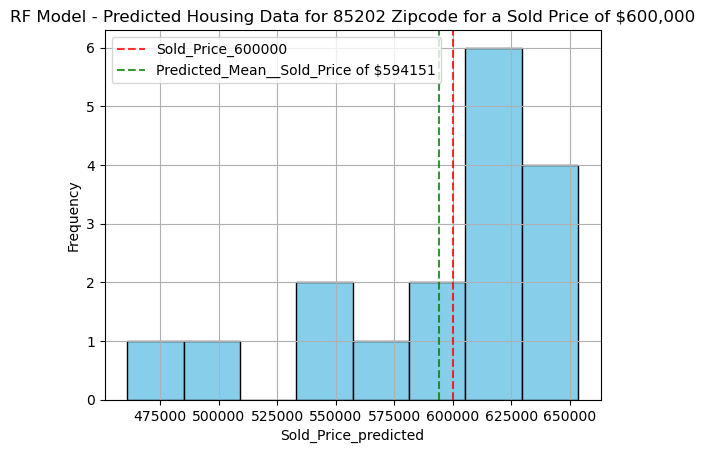

In [23]:
plt.hist(zipcode_85202_pred_rf, bins=8, color='skyblue', edgecolor='black')
plt.axvline(x=600000, c='r', ls='--', alpha=0.8, label='Sold_Price_600000')
plt.axvline(x=zipcode_85202_pred_rf.mean(), c='green', ls='--', alpha=0.8, label='Predicted_Mean__Sold_Price of $594151')
plt.xlabel('Sold_Price_predicted')
plt.ylabel('Frequency')
plt.title('RF Model - Predicted Housing Data for 85202 Zipcode for a Sold Price of $600,000')
plt.grid(True)
plt.legend()
plt.show()

 ### The Random Forest model predicted a house valued at \\$600,000 in zipcode 85202 will sell for a mean Sold Price of \\$594,151

## Load LR model

In [25]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = '../models/housing_pricing_lm_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        lm_model = pickle.load(f)
    if lm_model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if lm_model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model version doesn't match version loaded


### Load Data for LR model

In [26]:
housing_data_lm = pd.read_csv('../data/housing_data_lr_rf.csv')
housing_data_lm.dtypes

Zip_Code                   int64
Nr_Bedrooms                int64
Nr_Bathrooms             float64
Approx_SQFT                int64
Year_Built                 int64
                          ...   
Payment_Fixed              int64
Payment_Graduated          int64
Payment_Interest Only      int64
Payment_Missing            int64
Payment_Other              int64
Length: 63, dtype: object

In [27]:
X_lm = housing_data_lm.loc[housing_data_lm.Zip_Code != 85202, lm_model.X_columns]
y_lm = housing_data_lm.loc[housing_data_lm.Zip_Code != 85202, 'Sold_Price']

In [28]:
lm_model.fit(X_lm, y_lm)

LinearRegression()

In [29]:
cv_results = cross_validate(lm_model, X_lm, y_lm, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [30]:
cv_results['test_score']

array([-203581.24919812, -205959.4785427 , -201778.44169913,
       -314961.73217818, -235317.50046044])

In [31]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(232319.68041571183, 43109.67543025281)

### Calculate Expected Sold Price for a house in zipcode 85202 valued at 600,000 using LM Model

In [32]:
X_85202_lm = housing_data_lm.loc[housing_data_lm.Sold_Price == 600000, lm_model.X_columns]
y_85202_lm = housing_data_lm.loc[housing_data_lm.Sold_Price == 60000]

In [33]:
zipcode_85202_pred_lm = lm_model.predict(X_85202_lm)

In [34]:
zipcode_85202_pred_lm

array([ 240088.97071066,  634169.98446726,  668572.38212468,
        963478.6775246 ,  585615.53375574, 1196362.85936973,
       1070247.55061039,  594936.38075145,  436050.092994  ,
        600743.46827122,  408583.6756127 ,  445320.4191144 ,
        351847.46020346,  385337.10560952,  577726.42613516,
        644486.64585258,  792559.110045  ])

In [35]:
zipcode_85202_pred_lm.mean()

623301.573126621

In [36]:
zipcode_85202_pred_lm.min()

240088.97071065885

In [37]:
zipcode_85202_pred_lm.max()

1196362.859369726

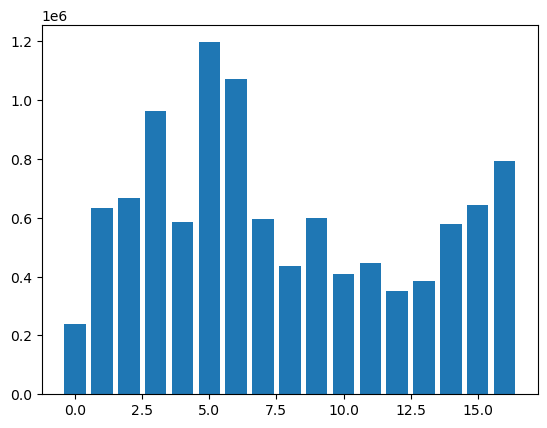

In [38]:
plt.bar(np.arange(len(zipcode_85202_pred_lm)),zipcode_85202_pred_lm)
plt.show()

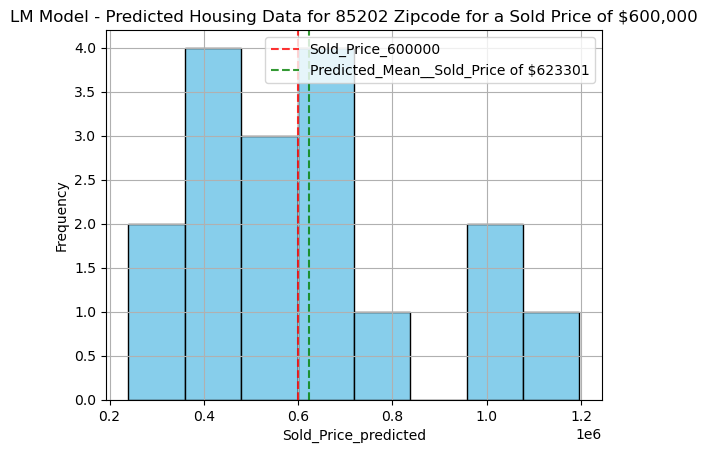

In [39]:
plt.hist(zipcode_85202_pred_lm, bins=8, color='skyblue', edgecolor='black')
plt.axvline(x=600000, c='r', ls='--', alpha=0.8, label='Sold_Price_600000')
plt.axvline(x=zipcode_85202_pred_lm.mean(), c='green', ls='--', alpha=0.8, label='Predicted_Mean__Sold_Price of $623301')
plt.xlabel('Sold_Price_predicted')
plt.ylabel('Frequency')
plt.title('LM Model - Predicted Housing Data for 85202 Zipcode for a Sold Price of $600,000')
plt.grid(True)
plt.legend()
plt.show()

### The Linear Regression model predicted a house valued at \\$600,000 in zipcode 85202 will sell for a mean Sold Price of \\$623,301.

## Load XGB model

In [40]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = '../models/housing_pricing_xgb_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        xgb_model = pickle.load(f)
    if xgb_model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if xgb_model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model version doesn't match version loaded


In [41]:
#df_xgb = pd.read_csv('../data/housing_data_xgb.csv')
#df_xgb.dtypes

In [42]:
housing_data.head()

,Zip_Code,Nr_Bedrooms,Nr_Bathrooms,Approx_SQFT,Year_Built,Approx_Lot_SqFt,HOA_Fee,Sold_Price,Garage_Spaces,Carport_Spaces,...,Loan_Other,Loan_USDA,Loan_VA,Payment_Adjustable,Payment_Balloon,Payment_Fixed,Payment_Graduated,Payment_Interest Only,Payment_Missing,Payment_Other
0,85003,1,1.0,720,1964,652,567.00,245000,0.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,85003,1,1.0,755,2005,751,631.00,325000,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
2,85003,4,3.0,3415,1940,11696,555.63,1500000,2.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,85003,1,1.0,710,2005,0,671.17,310000,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,85003,2,2.5,1510,2007,654,567.93,475000,2.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [43]:
X_xgb = housing_data.loc[housing_data.Zip_Code != 85202, xgb_model.X_columns]
y_xgb = housing_data.loc[housing_data.Zip_Code != 85202, 'Sold_Price']

In [45]:
import warnings
warnings.filterwarnings('ignore')

xgb_model.fit(X_xgb, y_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [46]:
cv_results = cross_validate(xgb_model, X_xgb, y_xgb, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [47]:
cv_results['test_score']

array([-188214.76411577,  -93159.46570122, -107160.62745173,
       -226666.81793699, -374111.41079776])

In [48]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(197862.6172006941, 101169.16642136719)

### Calculate Expected Sold Price for a house in Zipcode 85202 valued at 600,000 using XGB Model

In [51]:
X_85202_xgb = housing_data.loc[housing_data.Sold_Price == 600000, xgb_model.X_columns]
y_85202_xgb = housing_data.loc[housing_data.Sold_Price == 60000]

In [52]:
zipcode_85202_pred_xgb = xgb_model.predict(X_85202_xgb)

In [53]:
zipcode_85202_pred_xgb

array([498452.88, 588857.44, 494342.75, 672718.44, 515607.8 , 787064.8 ,
       781584.25, 579478.9 , 526829.1 , 587795.44, 523700.72, 573161.56,
       439263.9 , 716672.1 , 803538.75, 803538.75, 616626.2 ],
      dtype=float32)

In [54]:
zipcode_85202_pred_xgb.mean()

618190.25

In [55]:
zipcode_85202_pred_xgb.min()

439263.9

In [56]:
zipcode_85202_pred_xgb.max()

803538.75

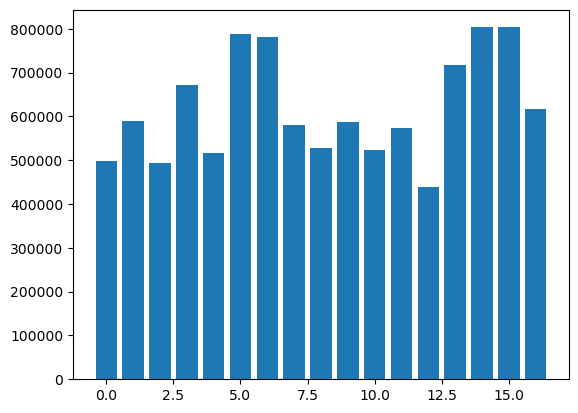

In [57]:
plt.bar(np.arange(len(zipcode_85202_pred_xgb)),zipcode_85202_pred_xgb)
plt.show()

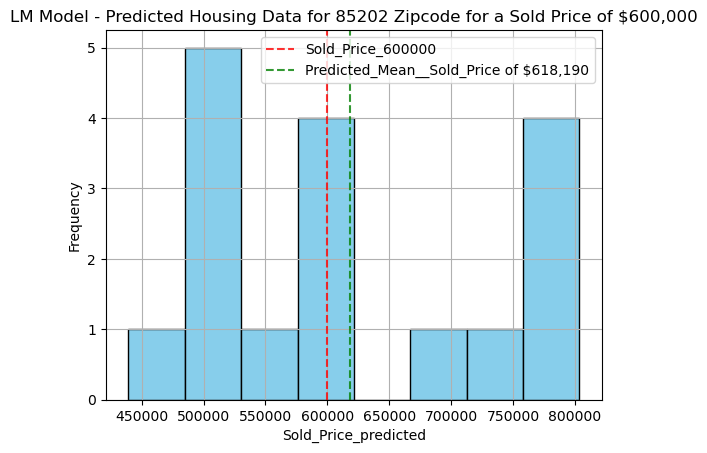

In [61]:
plt.hist(zipcode_85202_pred_xgb, bins=8, color='skyblue', edgecolor='black')
plt.axvline(x=600000, c='r', ls='--', alpha=0.8, label='Sold_Price_600000')
plt.axvline(x=zipcode_85202_pred_xgb.mean(), c='green', ls='--', alpha=0.8, label='Predicted_Mean__Sold_Price of $618,190')
plt.xlabel('Sold_Price_predicted')
plt.ylabel('Frequency')
plt.title('LM Model - Predicted Housing Data for 85202 Zipcode for a Sold Price of $600,000')
plt.grid(True)
plt.legend()
plt.show()

## Conclusion:

For a house valued at \\$600,000 in zipcode 85202 

- The Random Forest model predicted a Sold_Price of \\$594,151  ---     Diff of \\$5,849

- The XGB model predicted a Sold_Price of \\$623,301   ---       Diff of \\$23,301

- The Linear Regression model a Sold_Price of \\$618.190    ---      Diff of \\$18.190


The Random Forest Model has the smallest difference, is the best predictor.